In [4]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from kdg import kdn, kdcnn
from kdg.utils import generate_spirals, hellinger, plot_2dsim, generate_ood_samples, sample_unifrom_circle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from joblib import Parallel, delayed
from scipy.io import savemat, loadmat
from sklearn.metrics import roc_auc_score
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import activations

### Visualize the data

<AxesSubplot: >

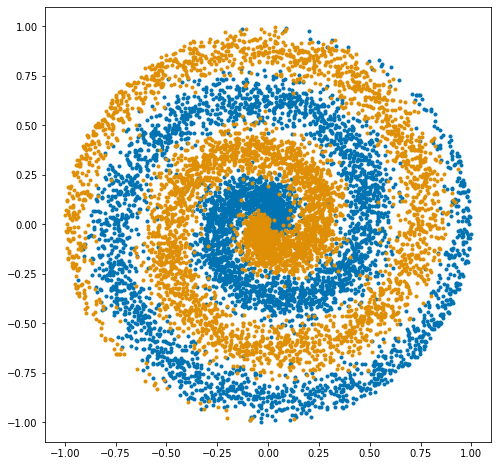

In [5]:
X, y = generate_spirals(10000)
plot_2dsim(X, y)

In [6]:
compile_kwargs = {
        "loss": "binary_crossentropy",
        "optimizer": keras.optimizers.Adam(3e-4),
    }
callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10, verbose=True)
fit_kwargs = {
        "epochs": 200,
        "batch_size": 64,
        "verbose": False,
        "callbacks": [callback],
    }

In [7]:
# network architecture [10, 10, 10, 10, 2]
def getNN(input_size, num_classes):
    network_base = keras.Sequential()
    initializer = keras.initializers.random_normal(seed=0)
    network_base.add(keras.layers.Dense(2000, kernel_initializer=initializer, input_shape=(input_size,)))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(2000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(2000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(2000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(units=num_classes, activation="softmax", kernel_initializer=initializer))
    network_base.compile(**compile_kwargs)
    return network_base

In [8]:
# train Vanilla NN
nn = getNN(input_size=2, num_classes=2)
history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

2023-03-03 20:39:10.256416: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-03 20:39:10.256560: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max


2023-03-03 20:39:10.500608: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-03 20:39:10.643678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 81: early stopping


### Calculate posteriors and likelihoods using KDN

In [16]:
df = {}
model_kdn = kdn(k=1.5, network=nn)
model_kdn.fit(X, y)

#define grids
p = np.arange(-3, 3, step=0.01)
q = np.arange(-3, 3, step=0.01)
xx, yy = np.meshgrid(p, q)

grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
posterior_nn = model_kdn.network.predict(grid_samples)
posterior_kdn, likelihoods_kdn = model_kdn.predict_proba(grid_samples, return_likelihood=True)

posterior_nn = posterior_nn[:,0].reshape(600,600)
posterior_kdn = posterior_kdn[:,0].reshape(600,600)
class1_likelihoods = likelihoods_kdn[:,0].reshape(600,600)
class2_likelihoods = likelihoods_kdn[:,1].reshape(600,600)

df['posterior_dn'] = posterior_nn
df['posterior_kdn'] = posterior_kdn
df['likelihood_class1'] = class1_likelihoods
df['likelihood_class2'] = class2_likelihoods


KeyboardInterrupt



In [17]:
a = model_kdn._get_polytope_ids(X)
print(a)

[[58797606612482168683461509075800963081119317732747446974099222481240361071366512509946632202525039229439434245424355933970915941206230375132728267369016374284857519923373141219212105402458391014658860022788413704101339801941708230768695040054897899803850696905622161428658026980233920913955106781630986787109579008101229634131812297284981326986797844700936936356613098683767810563792494833074303846439358236481467747951161023187843546601619370213043745894012470699195577037261493985501135836935709674313865129180856411283158480275982800146758565732482854175271724164025718343851976485276947774771102216
  600975758156257721303488891568177947088304285023533676338024074166127422661058252632745066305565078563283600731999016681182019686484282230754215252376193669051239430348368859147119309073276517029551363608075298019172167628380649180007587706029583574282898117705746900188543768968384542316292680275915688284016463596088809164420809267395748285817311423009771966138877907242698408625732152541245

In [27]:
for j in range(10000):
        model_kdn._count_ones(a[0]^a[0])

In [7]:
# get true posterior
tp_df = pd.read_csv("../true_posterior/spiral_pdf.csv")
proba_true = 0.5*np.ones((500, 500))
tmp = np.array([tp_df["posterior"][x] for x in range(40000)])
tmp = tmp.reshape(200, 200)
proba_true[150:350, 150:350] = 1 - tmp

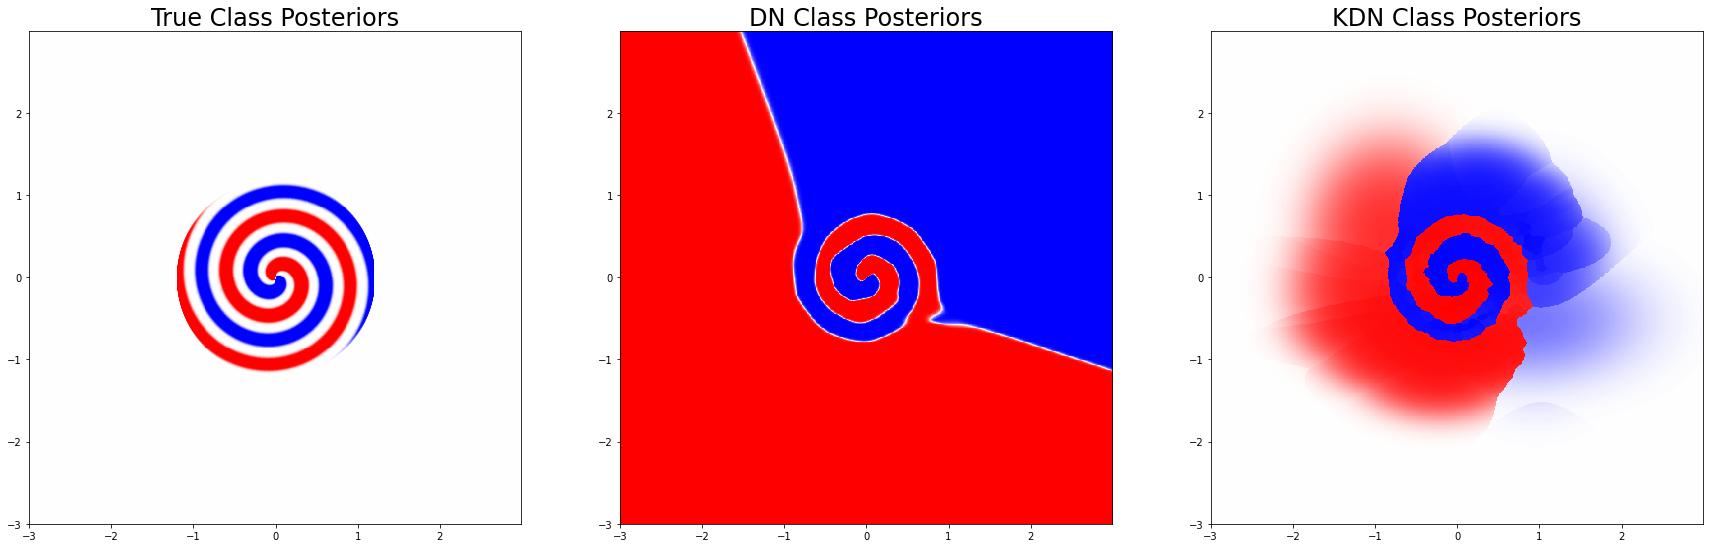

In [10]:
fig1, ax = plt.subplots(1, 3, figsize=(30, 90))

ax0 = ax[0].imshow(
    proba_true,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("True Class Posteriors", fontsize=24)
ax[0].set_aspect("equal")

ax1 = ax[1].imshow(
    1-posterior_nn,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("DN Class Posteriors", fontsize=24)
ax[1].set_aspect("equal")

ax2 = ax[2].imshow(
    1-posterior_kdn,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("KDN Class Posteriors", fontsize=24)
ax[2].set_aspect("equal")
plt.show()

### Visualize class likelihoods

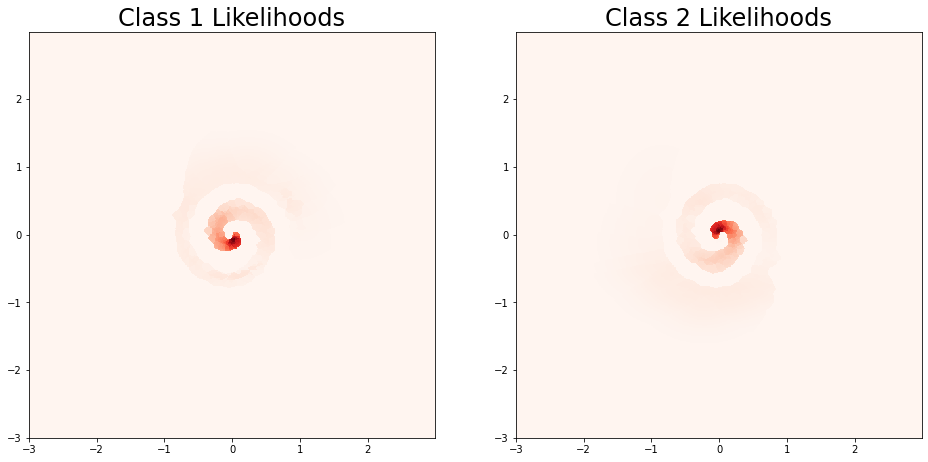

In [11]:
fig1, ax = plt.subplots(1, 2, figsize=(16, 8))

ax0 = ax[0].imshow(
    class1_likelihoods,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("Class 1 Likelihoods", fontsize=24)
ax[0].set_aspect("equal")


ax1 = ax[1].imshow(
    class2_likelihoods,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("Class 2 Likelihoods", fontsize=24)
ax[1].set_aspect("equal")

### Experiment with misclassification error and hellinger distance

In [22]:
mc_reps = 45
sample_size = [50, 100, 500, 1000, 5000, 10000]
n_test = 1000

tp_df = pd.read_csv("../true_posterior/spiral_pdf.csv")
true_posterior = tp_df['posterior']
true_posterior = np.vstack((1-true_posterior.ravel(), true_posterior.ravel())).T
        
    
def experiment_in(sample, n_test, true_posterior):
    X, y = generate_spirals(sample)
    X_test, y_test = generate_spirals(n_test)

    p = np.arange(-1, 1, step=0.01)
    q = np.arange(-1, 1, step=0.01)
    xx, yy = np.meshgrid(p, q)

    grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

    model_kdf = kdf(k=.2, kwargs={'n_estimators':500})
    model_kdf.fit(X, y)

    error_kdf = 1 - np.mean(model_kdf.predict(X_test)==y_test)
    error_rf = 1 - np.mean(model_kdf.rf_model.predict(X_test)==y_test)
    proba_kdf = model_kdf.predict_proba(grid_samples)
    proba_rf = model_kdf.rf_model.predict_proba(grid_samples)
    hellinger_dis_kdf = hellinger(1-true_posterior, proba_kdf)
    hellinger_dis_rf = hellinger(1-true_posterior, proba_rf)
    mmcIn_rf = np.mean(np.max(proba_rf, axis=1)) 
    mmcIn_kdf = np.mean(np.max(proba_kdf, axis=1))
    
    return error_kdf, error_rf, hellinger_dis_kdf, hellinger_dis_rf, mmcIn_kdf, mmcIn_rf

def experiment_out(in_sample, r, n_test):
    X, y = generate_spirals(in_sample)
    model_kdf = kdf(k=.2, kwargs={'n_estimators':500})
    model_kdf.fit(X, y)

    X_ood = sample_unifrom_circle(n=n_test, r=r)
    mmcOut_rf = np.mean(np.max(model_kdf.rf_model.predict_proba(X_ood), axis=1))
    mmcOut_kdf = np.mean(np.max(model_kdf.predict_proba(X_ood), axis=1))
    
    return mmcOut_kdf, mmcOut_rf
        
    
error_kdf_med = []
error_kdf_25 = []
error_kdf_75 = []
error_rf_med = []
error_rf_25 = []
error_rf_75 = []

hellinger_kdf_med = []
hellinger_kdf_25 = []
hellinger_kdf_75 = []
hellinger_rf_med = []
hellinger_rf_25 = []
hellinger_rf_75 = []

mmcIn_kdf_med = []
mmcIn_kdf_25 = []
mmcIn_kdf_75 = []
mmcIn_rf_med = []
mmcIn_rf_25 = []
mmcIn_rf_75 = []

mmcOut_kdf_med = []
mmcOut_kdf_25 = []
mmcOut_kdf_75 = []
mmcOut_rf_med = []
mmcOut_rf_25 = []
mmcOut_rf_75 = []

#### do out-of-distribution results ####
for r in np.arange(0,10.5,.5):
    mmcOut_kdf = []
    mmcOut_rf = []
    res = Parallel(n_jobs=-1)(
            delayed(experiment_out)(
                    1000,
                    r,
                    n_test
                    ) for _ in range(mc_reps)
                )
    
    for ii in range(mc_reps):
        mmcOut_kdf.append(res[ii][0])
        mmcOut_rf.append(res[ii][1])
    
    
    mmcOut_kdf_med.append(
        np.median(mmcOut_kdf)
    )
    mmcOut_kdf_25.append(
        np.quantile(mmcOut_kdf, [0.25])[0]
    )
    mmcOut_kdf_75.append(
        np.quantile(mmcOut_kdf, [0.75])[0]
    )
    
    mmcOut_rf_med.append(
        np.median(mmcOut_rf)
    )
    mmcOut_rf_25.append(
        np.quantile(mmcOut_rf, [0.25])[0]
    )
    mmcOut_rf_75.append(
        np.quantile(mmcOut_rf, [0.75])[0]
    )
    
    
#### do in-distribution results ####
for sample in sample_size:
    res = Parallel(n_jobs=-1)(
            delayed(experiment_in)(
                    sample,
                    n_test,
                    true_posterior
                    ) for _ in range(mc_reps)
                )

    
    err_kdf = []
    err_rf = []
    hellinger_kdf = []
    hellinger_rf = []
    mmcIn_kdf = []
    mmcIn_rf = []
    for ii in range(mc_reps):
        err_kdf.append(res[ii][0])
        err_rf.append(res[ii][1])
        hellinger_kdf.append(res[ii][2])
        hellinger_rf.append(res[ii][3])
        mmcIn_kdf.append(res[ii][4])
        mmcIn_rf.append(res[ii][5])

    error_kdf_med.append(
        np.median(err_kdf)
    )
    error_kdf_25.append(
        np.quantile(err_kdf, [0.25])[0]
    )
    error_kdf_75.append(
        np.quantile(err_kdf, [0.75])[0]
    )

    error_rf_med.append(
        np.median(err_rf)
    )
    error_rf_25.append(
        np.quantile(err_rf, [0.25])[0]
    )
    error_rf_75.append(
        np.quantile(err_rf, [0.75])[0]
    )
    
    hellinger_kdf_med.append(
        np.median(hellinger_kdf)
    )
    hellinger_kdf_25.append(
        np.quantile(hellinger_kdf, [0.25])[0]
    )
    hellinger_kdf_75.append(
        np.quantile(hellinger_kdf, [0.75])[0]
    )

    hellinger_rf_med.append(
        np.median(hellinger_rf)
    )
    hellinger_rf_25.append(
        np.quantile(hellinger_rf, [0.25])[0]
    )
    hellinger_rf_75.append(
        np.quantile(hellinger_rf, [0.75])[0]
    )

    mmcIn_kdf_med.append(
        np.median(mmcIn_kdf)
    )
    mmcIn_kdf_25.append(
        np.quantile(mmcIn_kdf, [0.25])[0]
    )
    mmcIn_kdf_75.append(
        np.quantile(mmcIn_kdf, [0.75])[0]
    )

    mmcIn_rf_med.append(
        np.median(mmcIn_rf)
    )
    mmcIn_rf_25.append(
        np.quantile(mmcIn_rf, [0.25])[0]
    )
    mmcIn_rf_75.append(
        np.quantile(mmcIn_rf, [0.75])[0]
    )


df['error_kdf_med'] = error_kdf_med
df['error_kdf_25'] = error_kdf_25
df['error_kdf_75'] = error_kdf_75

df['error_rf_med'] = error_rf_med
df['error_rf_25'] = error_rf_25
df['error_rf_75'] = error_rf_75

df['hellinger_kdf_med'] = hellinger_kdf_med
df['hellinger_kdf_25'] = hellinger_kdf_25
df['hellinger_kdf_75'] = hellinger_kdf_75

df['hellinger_rf_med'] = hellinger_rf_med
df['hellinger_rf_25'] = hellinger_rf_25
df['hellinger_rf_75'] = hellinger_rf_75

df['mmcIn_kdf_med'] = mmcIn_kdf_med
df['mmcIn_kdf_25'] = mmcIn_kdf_25
df['mmcIn_kdf_75'] = mmcIn_kdf_75

df['mmcIn_rf_med'] = mmcIn_rf_med
df['mmcIn_rf_25'] = mmcIn_rf_25
df['mmcIn_rf_75'] = mmcIn_rf_75

df['mmcOut_kdf_med'] = mmcOut_kdf_med
df['mmcOut_kdf_25'] = mmcOut_kdf_25
df['mmcOut_kdf_75'] = mmcOut_kdf_75

df['mmcOut_rf_med'] = mmcOut_rf_med
df['mmcOut_rf_25'] = mmcOut_rf_25
df['mmcOut_rf_75'] = mmcOut_rf_75

/Users/jayantadey/miniforge3/envs/env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/jayantadey/miniforge3/envs/env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/jayantadey/miniforge3/envs/env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/jayantadey/miniforge3/envs/env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of S

### Save the result

In [23]:
name = 'spiral'
filename = name + "_plot_data.mat"
savemat(filename, df)

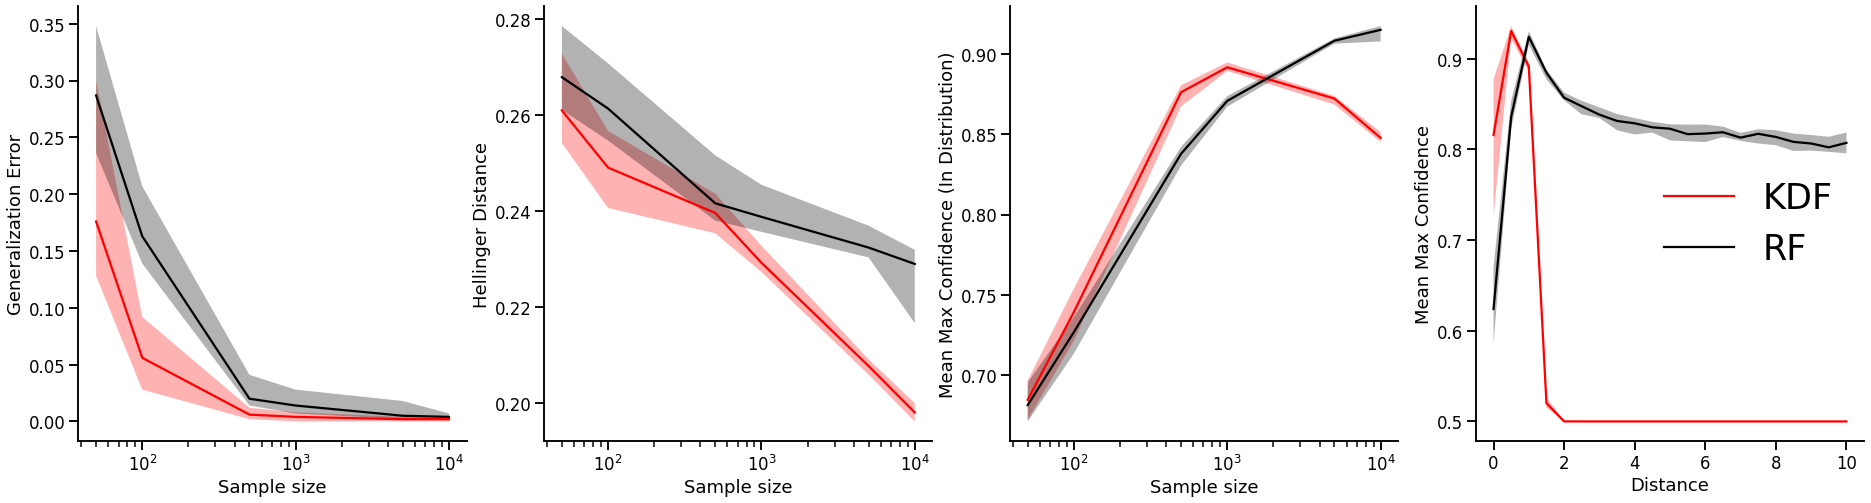

In [24]:
sample_size = [50, 100, 500, 1000, 5000, 10000]

sns.set_context('talk')
fig, ax = plt.subplots(1,4, figsize=(32,8))

ax[0].plot(sample_size, df['error_kdf_med'], c="r", label='KDF')
ax[0].plot(sample_size, df['error_rf_med'], c="k", label='RF')

ax[0].fill_between(sample_size, df['error_kdf_25'], df['error_kdf_75'], facecolor='r', alpha=.3)
ax[0].fill_between(sample_size, df['error_rf_25'], df['error_rf_75'], facecolor='k', alpha=.3)

ax[0].set_xscale('log')
ax[0].set_xlabel('Sample size')
ax[0].set_ylabel('Generalization Error')

right_side = ax[0].spines["right"]
right_side.set_visible(False)
top_side = ax[0].spines["top"]
top_side.set_visible(False)




ax[1].plot(sample_size, df['hellinger_kdf_med'], c="r", label='KDF')
ax[1].plot(sample_size, df['hellinger_rf_med'], c="k", label='RF')

ax[1].fill_between(sample_size, df['hellinger_kdf_25'], df['hellinger_kdf_75'], facecolor='r', alpha=.3)
ax[1].fill_between(sample_size, df['hellinger_rf_25'], df['hellinger_rf_75'], facecolor='k', alpha=.3)

ax[1].set_xscale('log')
ax[1].set_xlabel('Sample size')
ax[1].set_ylabel('Hellinger Distance')

right_side = ax[1].spines["right"]
right_side.set_visible(False)
top_side = ax[1].spines["top"]
top_side.set_visible(False)




ax[2].plot(sample_size, df['mmcIn_kdf_med'], c="r", label='KDF')
ax[2].plot(sample_size, df['mmcIn_rf_med'], c="k", label='RF')

ax[2].fill_between(sample_size, df['mmcIn_kdf_25'], df['mmcIn_kdf_75'], facecolor='r', alpha=.3)
ax[2].fill_between(sample_size, df['mmcIn_rf_25'], df['mmcIn_rf_75'], facecolor='k', alpha=.3)

ax[2].set_xscale('log')
ax[2].set_xlabel('Sample size')
ax[2].set_ylabel('Mean Max Confidence (In Distribution)')

right_side = ax[2].spines["right"]
right_side.set_visible(False)
top_side = ax[2].spines["top"]
top_side.set_visible(False)


r = np.arange(0,10.5,.5)
ax[3].plot(r, df['mmcOut_kdf_med'], c="r", label='KDF')
ax[3].plot(r, df['mmcOut_rf_med'], c="k", label='RF')

ax[3].fill_between(r, df['mmcOut_kdf_25'], df['mmcOut_kdf_75'], facecolor='r', alpha=.3)
ax[3].fill_between(r, df['mmcOut_rf_25'], df['mmcOut_rf_75'], facecolor='k', alpha=.3)

#ax[3].set_xscale('log')
ax[3].set_xlabel('Distance')
ax[3].set_ylabel('Mean Max Confidence')

ax[3].legend(fontsize=35, frameon=False)

right_side = ax[3].spines["right"]
right_side.set_visible(False)
top_side = ax[3].spines["top"]
top_side.set_visible(False)

### OOD detection metrics

In [17]:
def fpr_at_95_tpr(conf_t, conf_f):
    TPR = 95
    PERC = np.percentile(conf_t, 100-TPR)
    FP = np.sum(conf_f >=  PERC)
    FPR = np.sum(conf_f >=  PERC)/len(conf_f)
    return FPR, PERC

In [18]:
sample = 10000
reps = 45
n_test = 1000
true_labels = np.hstack((np.ones(n_test, ), np.zeros(n_test, )))

roc_rf = []
roc_kdf = []

fpr_rf = []
fpr_kdf = []
reps_list = []

for ii in range(reps):
    X, y = generate_spirals(sample)
    X_test, y_test = generate_spirals(n_test)
    X_ood = generate_ood_samples(n_test)

    
    model_kdf = kdf(kwargs={'n_estimators':500})
    model_kdf.fit(X, y)

    rf_in_conf = np.max(model_kdf.rf_model.predict_proba(X_test), axis=1)
    rf_out_conf = np.max(model_kdf.rf_model.predict_proba(X_ood), axis=1)
    rf_conf = np.hstack((rf_in_conf, rf_out_conf))
    roc_rf.append(
        roc_auc_score(true_labels, rf_conf)
    )
    fpr_rf.append(
        fpr_at_95_tpr(rf_in_conf, rf_out_conf)
    )
    
    

    kdf_in_conf = np.max(model_kdf.predict_proba(X_test), axis=1)
    kdf_out_conf = np.max(model_kdf.predict_proba(X_ood), axis=1)
    kdf_conf = np.hstack((kdf_in_conf, kdf_out_conf))
    roc_kdf.append(
        roc_auc_score(true_labels, kdf_conf)
    )
    fpr_kdf.append(
        fpr_at_95_tpr(kdf_in_conf, kdf_out_conf)
    )

    reps_list.append(ii)

In [19]:
# obtain the AUROC and FPR@95 scores

# AUROC
print("KDF AUROC = {:.3f} +/- {:.3f}".format(np.mean(roc_kdf), np.std(roc_kdf)))
print("RF AUROC = {:.3f} +/- {:.3f}".format(np.mean(roc_rf), np.std(roc_rf)))

KDF AUROC = 0.978 +/- 0.004
RF AUROC = 0.550 +/- 0.019


In [20]:
# FPR@95
print("KDF FPR@95 = {:.3f} +/- {:.3f}".format(np.mean(fpr_kdf), np.std(fpr_kdf)))
print("RF FPR@95 = {:.3f} +/- {:.3f}".format(np.mean(fpr_rf), np.std(fpr_rf)))

KDF FPR@95 = 0.527 +/- 0.461
RF FPR@95 = 0.758 +/- 0.167


In [12]:
model_kdn.global_bias

-19.59216177976422

In [2]:
X, y = generate_spirals(1000)

compile_kwargs = {
        "loss": "binary_crossentropy",
        "optimizer": keras.optimizers.Adam(3e-4),
    }
callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10, verbose=True)
fit_kwargs = {
        "epochs": 200,
        "batch_size": 64,
        "verbose": False,
        "callbacks": [callback],
    }


# network architecture [10, 10, 10, 10, 2]
def getNN(input_size, num_classes):
    network_base = keras.Sequential()
    initializer = keras.initializers.random_normal(seed=0)
    network_base.add(keras.layers.Dense(500, kernel_initializer=initializer, input_shape=(input_size,)))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(500, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(500, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(500, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(units=num_classes, activation="softmax", kernel_initializer=initializer))
    network_base.compile(**compile_kwargs)
    return network_base


# train Vanilla NN
nn = getNN(input_size=2, num_classes=2)
history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

Metal device set to: Apple M1 Max


2023-01-12 13:43:22.822386: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-12 13:43:22.822807: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-01-12 13:43:22.957874: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-12 13:43:23.089204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 56: early stopping


In [3]:
model_kdn = kdn(k=.4, network=nn)
model_kdn.fit(X, y)

In [4]:
model_kdcnn = kdcnn(k=.4, network=nn)
model_kdcnn.fit(X, y)

In [9]:
model_kdn.predict_proba(X[:20])

array([[9.99993592e-01, 6.40798216e-06],
       [9.99993592e-01, 6.40798464e-06],
       [9.99993592e-01, 6.40799498e-06],
       [9.99993592e-01, 6.40804793e-06],
       [9.99998932e-01, 1.06799419e-06],
       [9.99993583e-01, 6.41659782e-06],
       [9.99993583e-01, 6.41656592e-06],
       [9.99993583e-01, 6.41722799e-06],
       [9.99993554e-01, 6.44596627e-06],
       [9.99993514e-01, 6.48607703e-06],
       [9.99993513e-01, 6.48735684e-06],
       [9.99993514e-01, 6.48647081e-06],
       [9.99993505e-01, 6.49484164e-06],
       [9.99993479e-01, 6.52084864e-06],
       [9.99993488e-01, 6.51188939e-06],
       [9.99993476e-01, 6.52372687e-06],
       [9.99993462e-01, 6.53833485e-06],
       [9.99993454e-01, 6.54557372e-06],
       [9.99993448e-01, 6.55204267e-06],
       [9.99993486e-01, 6.51426084e-06]])

In [10]:
model_kdcnn.predict_proba(X[:20])

array([[9.99993592e-01, 6.40798216e-06],
       [9.99993592e-01, 6.40798464e-06],
       [9.99993592e-01, 6.40799498e-06],
       [9.99993592e-01, 6.40804793e-06],
       [9.99998932e-01, 1.06799419e-06],
       [9.99993583e-01, 6.41659782e-06],
       [9.99993583e-01, 6.41656592e-06],
       [9.99993583e-01, 6.41722799e-06],
       [9.99993554e-01, 6.44596627e-06],
       [9.99993514e-01, 6.48607703e-06],
       [9.99993513e-01, 6.48735684e-06],
       [9.99993514e-01, 6.48647081e-06],
       [9.99993505e-01, 6.49484164e-06],
       [9.99993479e-01, 6.52084864e-06],
       [9.99993488e-01, 6.51188939e-06],
       [9.99993476e-01, 6.52372687e-06],
       [9.99993462e-01, 6.53833485e-06],
       [9.99993454e-01, 6.54557372e-06],
       [9.99993448e-01, 6.55204267e-06],
       [9.99993486e-01, 6.51426084e-06]])

In [7]:
model_kdn.polytope_cov

[array([0.0659995, 0.0676658]),
 array([0.06604984, 0.06750809]),
 array([0.06527083, 0.06747271]),
 array([0.06615727, 0.06790352]),
 array([0.06601703, 0.06782147]),
 array([0.06617896, 0.06763289]),
 array([0.06644707, 0.06776312]),
 array([0.06633755, 0.0677408 ]),
 array([0.06652372, 0.06768971]),
 array([0.06635044, 0.06769489]),
 array([0.06639366, 0.06771239]),
 array([0.06598412, 0.06761669]),
 array([0.06694736, 0.0678725 ]),
 array([0.0669691 , 0.06793619]),
 array([0.06729175, 0.06801491]),
 array([0.06672683, 0.06807528]),
 array([0.06667633, 0.06825946]),
 array([0.06697324, 0.0680163 ]),
 array([0.06821999, 0.07028543]),
 array([0.06747976, 0.06872361]),
 array([0.06744885, 0.06838042]),
 array([0.06860132, 0.0706517 ]),
 array([0.06868417, 0.07038339]),
 array([0.06837138, 0.07104121]),
 array([0.06857899, 0.07122967]),
 array([0.06795967, 0.07055486]),
 array([0.0692697 , 0.07209948]),
 array([0.07004127, 0.07263702]),
 array([0.06790103, 0.07118865]),
 array([0.068342

In [8]:
model_kdcnn.polytope_cov

[array([0.06448302, 0.06718064]),
 array([0.06443288, 0.06722754]),
 array([0.06451476, 0.0673276 ]),
 array([0.06489184, 0.06755117]),
 array([0.06535014, 0.06791484]),
 array([0.06537663, 0.06791412]),
 array([0.06535897, 0.06791392]),
 array([0.0654188 , 0.06802704]),
 array([0.06577098, 0.06820576]),
 array([0.06580485, 0.06798344]),
 array([0.06589521, 0.06813728]),
 array([0.06595069, 0.06838519]),
 array([0.06618998, 0.06828893]),
 array([0.06628643, 0.06832442]),
 array([0.06597665, 0.06785582]),
 array([0.06622613, 0.06790485]),
 array([0.06640457, 0.06826555]),
 array([0.06645123, 0.06849903]),
 array([0.06633918, 0.06816689]),
 array([0.06636156, 0.0680231 ]),
 array([0.06626662, 0.06795949]),
 array([0.06644607, 0.06829245]),
 array([0.06685424, 0.06835005]),
 array([0.06674177, 0.06828255]),
 array([0.06697354, 0.06851544]),
 array([0.06696338, 0.06839102]),
 array([0.06744539, 0.06873882]),
 array([0.06745572, 0.06831806]),
 array([0.06766324, 0.06842312]),
 array([0.0675